In [1]:
import sys
sys.path.append("..")
from lazydiff.vars import Var
from lazydiff import ops
import numpy as np
from lazydiff import regression
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
%matplotlib notebook

In [2]:
dim = 1

In [3]:
X,y,true_coef = make_regression(n_samples = 100, n_features = dim, n_informative = dim, bias = 10, \
                                coef = True, noise = 0, random_state=1)

In [4]:
def plot_regression(X, y, history, predict = None, step = 1, reference_regression = None):
    
    # default standard prediction of y
    if (predict == None):
        predict = lambda X, m, b: X*m+b
            
    plt.figure()
    plt_range = np.linspace(min(X[:,0]),max(X[:,0]),100)#np.concatenate([min(X),max(X)]
    fig,ax = plt.subplots(1,1)
    plt.scatter(X[:,0],y)
    plt.ion()
    m, b = history['m'][0], history['b'][0]
    line, = plt.plot(plt_range, predict(plt_range, m, b), color = 'black', label = 'gradient descent linear regression')
    if (reference_regression):
        clf = reference_regression.fit(X,y)
        plt.plot(plt_range, clf.coef_*plt_range+clf.intercept_, alpha = 0.3, label = 'sklearn regression')
    plt.xlabel("x value")
    plt.ylabel("y value")
    plt.legend()
    fig.canvas.draw()
    
    for i, (m, b, loss) in enumerate(zip(history['m'],history['b'],history['loss'])):
        if (i%step == 0):
            line.set_ydata(predict(plt_range, m, b))
            ax.set_title("Iterative Regression Update epoch = {}\nMSE={:.2E}".format(i, float(loss)))
            fig.canvas.draw()
            # pause
            plt.pause(0.1)

Let's first look at how our iterative regression updates over each epoch!

<IPython.core.display.Javascript object>


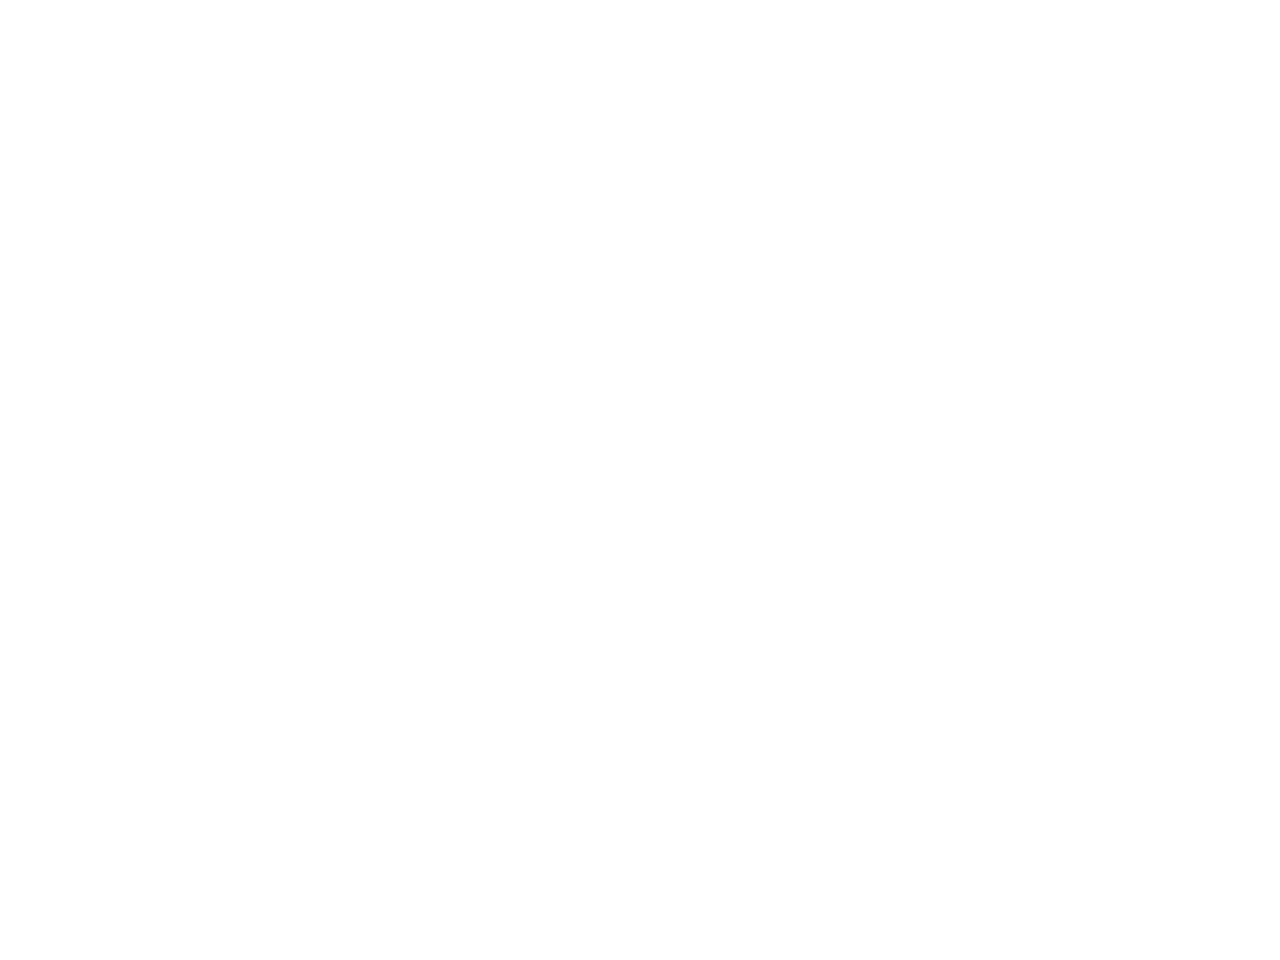

<IPython.core.display.Javascript object>


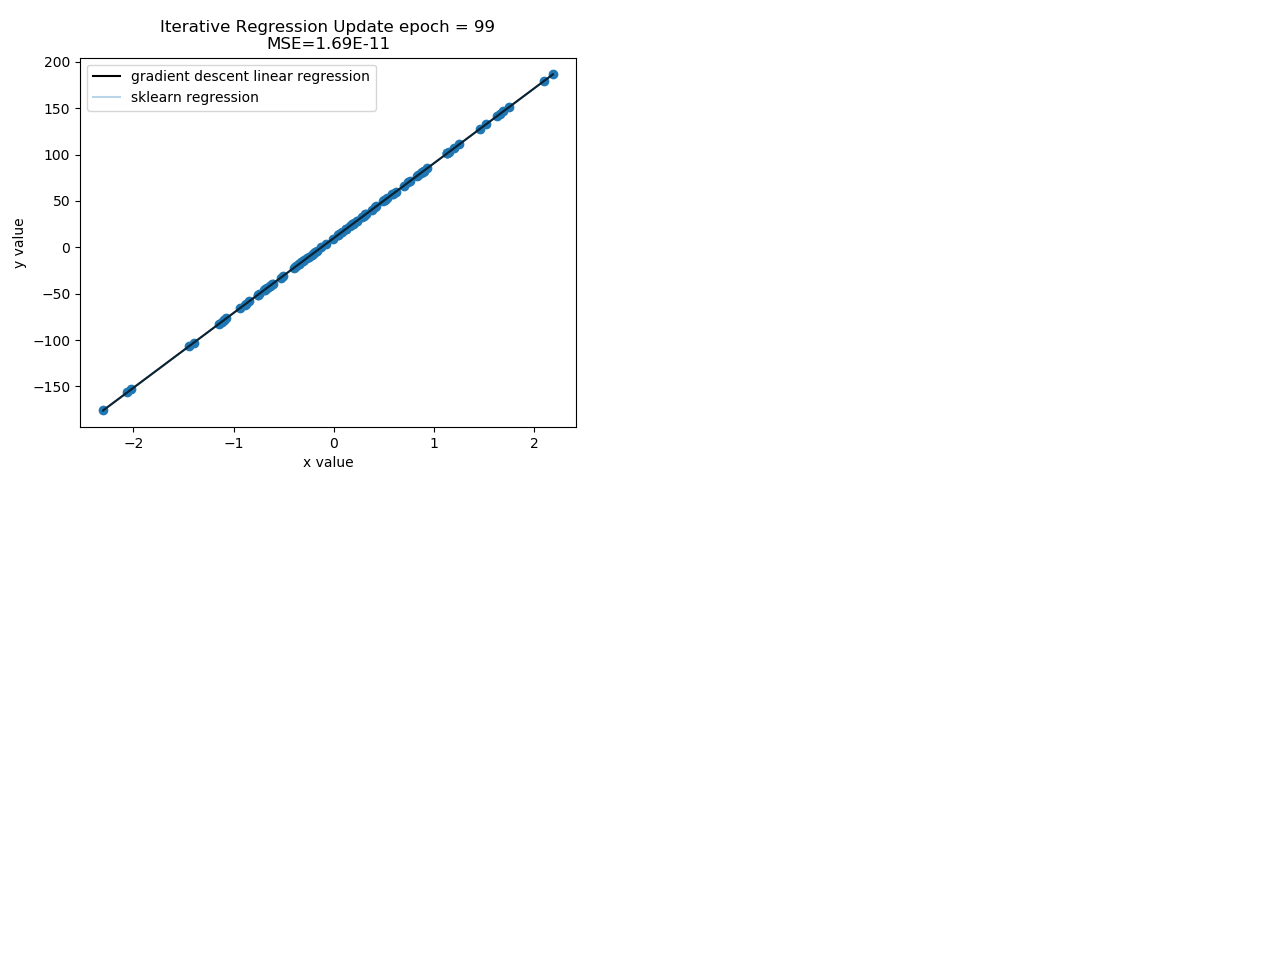

In [5]:
%matplotlib notebook

m = Var(np.ones(X.shape[1]))
b = Var(0)
earlyStop = 0
plot = True
forward = True
linear_history = {}
m, b, loss = regression.iterative_regression(X, y, m, b, regression.MSE, 0.1, 100,
                                                    earlyStop, forward, linear_history)

plot_regression(X, y, linear_history, None, 1, LinearRegression())

In [6]:
# linear regression
clf = LinearRegression().fit(X,y)
## check that getting close results
print("Difference between iterative and sklearn linear regression")
print("Coefficient: {}".format(m.val - clf.coef_))
print("Intercept: {}".format(b.val - clf.intercept_))

Difference between iterative and sklearn linear regression
Coefficient: [-3.82769228e-06]
Intercept: 1.0089887698683242e-06


Now let's test how much time forward and reverse mode (backpropagation) take to get the gradients.

Since increasing by a dimension of 100 is not very noticeable, we decide to increase by 1000 each time.

In [7]:
def timer(f):
    """
    timer decorator from CS207 lecture 4
    """
    def inner(*args):
        t0 = time.time()
        output = f(*args)
        elapsed = time.time() - t0
        print("Time Elapsed", elapsed)
        return output, elapsed
    return inner

timed_regression = timer(regression.iterative_regression)

In [8]:
time_forward = []
time_backward = []
dim_range = np.arange(10,11000,1000)
# checking performance varying dimension
for dim in dim_range:
    print("working on dim={}".format(dim), end='\r')
    X, y= make_regression(n_samples = 100, n_features = dim, n_informative = dim, bias = 10, \
                                coef = False, noise = 0, random_state=1)
    # no earlyStop
    earlyStop = 0
    
    forward = True
    m = Var(np.ones(X.shape[1]))
    b = Var(0)
    _, elapsed = timed_regression(X, y, m, b, regression.MSE, 0.1, 100, earlyStop, forward)
    time_forward.append(elapsed)
    
    forward = False
    m = Var(np.ones(X.shape[1]))
    b = Var(0)
    _, elapsed = timed_regression(X, y, m, b, regression.MSE, 0.1, 100, earlyStop, forward)
    time_backward.append(elapsed)

Time Elapsed 1.406275749206543
Time Elapsed 0.8978168964385986
Time Elapsed 1.561156988143921
Time Elapsed 1.0238940715789795
Time Elapsed 2.1166560649871826
Time Elapsed 1.1438441276550293
Time Elapsed 2.3579728603363037
Time Elapsed 1.4448180198669434
Time Elapsed 2.6979668140411377
Time Elapsed 1.4951202869415283
Time Elapsed 2.9335312843322754
Time Elapsed 1.5112903118133545
Time Elapsed 3.31146502494812
Time Elapsed 1.7337439060211182
Time Elapsed 3.611476182937622
Time Elapsed 1.7857091426849365
Time Elapsed 4.085654973983765
Time Elapsed 2.3666810989379883
Time Elapsed 4.274241209030151
Time Elapsed 2.0152249336242676
Time Elapsed 4.93248987197876
Time Elapsed 2.231027841567993


Text(0.5,1,'Numpy Implementation:\nForward vs reverse mode differentiation performance on linear regression')

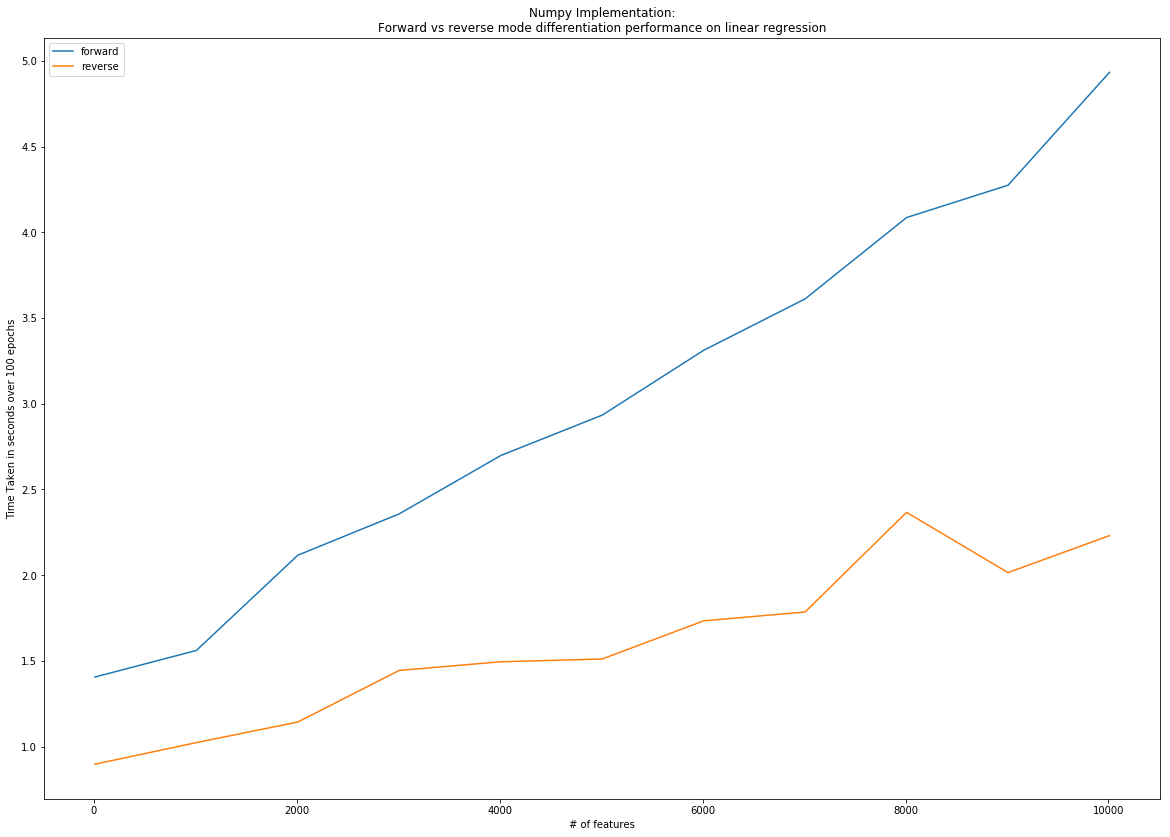

In [9]:
%matplotlib inline
plt.figure(figsize=(20,14))
plt.plot(dim_range, time_forward, label='forward')
plt.plot(dim_range, time_backward, label='reverse')
plt.legend()
plt.xlabel("# of features")
plt.ylabel("Time Taken in seconds over 100 epochs")
plt.title("Numpy Implementation:\nForward vs reverse mode differentiation performance on linear regression")

The result looks as expected, where the increase of forward mode is much steeper than the reverse mode. This shows how backpropagation is better than forward mode in cases where there are a lot of inputs to the loss, but small number of outputs.

#### Lasso, Ridge and Elastic Net

Let's now test that our Lasso, Ridge and Elastic Net implementation also work correctly with some noisy regression data

In [10]:
dim = 2
X,y,true_coef = make_regression(n_samples = 100, n_features = dim, n_informative = dim, bias = 10, \
                                coef = True, noise = 1, random_state=1)

In [11]:
m_lasso = Var(np.ones(X.shape[1]))
b_lasso = Var(0)
earlyStop = 0 #1e-8
forward = False
epochs = 300
lr = 0.1
m_lasso, b_lasso, loss = regression.iterative_regression(X, y, m_lasso, b_lasso, regression.lasso_loss, lr, epochs,
                                                    earlyStop, forward)

In [12]:
## check that we're getting close results
clf_l1 = Lasso().fit(X,y)
print("Difference between iterative and sklearn Ridge regression")
print("Coefficient: {}".format(m_lasso.val - clf_l1.coef_))
print("Intercept: {}".format(b_lasso.val - clf_l1.intercept_))

Difference between iterative and sklearn Ridge regression
Coefficient: [8.63388706e-05 1.30656280e-05]
Intercept: -1.6942516758433612e-06


In [13]:
m_ridge = Var(np.ones(X.shape[1]))
b_ridge = Var(0)
earlyStop = 0 #1e-8
forward = False
epochs = 300
# need to use a very small learning rate for Ridge
# if not it blows up
lr = 0.001
m_ridge, b_ridge, loss = regression.iterative_regression(X, y, m_ridge, b_ridge, regression.ridge_loss, lr, epochs,
                                                    earlyStop, forward)

In [14]:
## check that we're getting close results
clf_l2 = Ridge().fit(X,y)
print("Difference between iterative and sklearn Ridge regression")
print("Coefficient: {}".format(m_ridge.val - clf_l2.coef_))
print("Intercept: {}".format(b_ridge.val - clf_l2.intercept_))

Difference between iterative and sklearn Ridge regression
Coefficient: [0. 0.]
Intercept: -8.881784197001252e-15


In [15]:
m_el = Var(np.ones(X.shape[1]))
b_el = Var(0)
earlyStop = 0 #1e-8
forward = False
epochs = 300
lr = 0.1
m_el, b_el, loss = regression.iterative_regression(X, y, m_el, b_el, regression.elastic_loss, lr, epochs,
                                                    earlyStop, forward)

In [16]:
## check that we're getting close results
clf_el = ElasticNet().fit(X,y)
print("Difference between iterative and sklearn Ridge regression")
print("Coefficient: {}".format(m_el.val - clf_el.coef_))
print("Intercept: {}".format(b_el.val - clf_el.intercept_))

Difference between iterative and sklearn Ridge regression
Coefficient: [1.80313935e-06 1.66684259e-07]
Intercept: -1.3828518774516851e-08


All the results are similar to that of sklearn, this means our regression extensions are working correctly!

### Polynomial Regression

This also works with polynomial regression by extending the matrix X with polynomial fit.

Let's test this out on $y = x^3-10x^2+3$ and plot this to see how this works!

In [17]:
# define a custom prediction function

def predict(X, m, b):
    if (X.ndim == 1):
        new_X = X.reshape(-1,1)
        new_X = PolynomialFeatures(3, include_bias = False).fit_transform(new_X)
    else:
        new_X = X
    return np.sum(m*new_X, axis=1)+b

In [18]:
# construct the data
X = np.linspace(-10,10,20).reshape(-1,1)

y = X**3-10*X**2+3
X = PolynomialFeatures(3, include_bias = False).fit_transform(X)

In [19]:
m = Var(np.random.rand(X.shape[1]), seed = 1.0)
b = Var(0)
earlyStop = 1e-8
forward = False
poly_history = {}
m, b, loss = regression.iterative_regression(X, y, m, b, regression.MSE, 0.000001, 10000,
                                                    earlyStop, forward, poly_history)

<IPython.core.display.Javascript object>


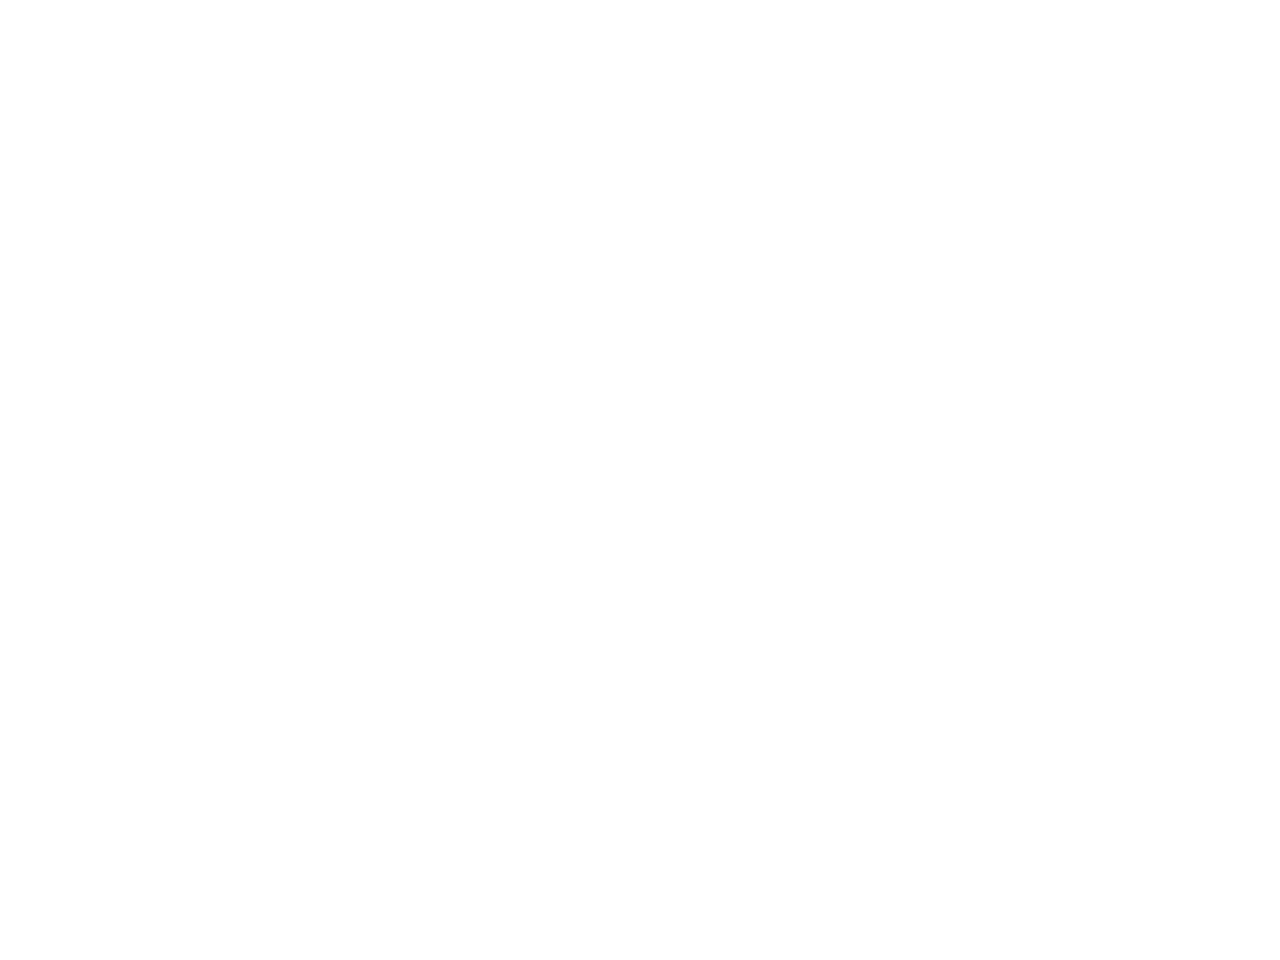

<IPython.core.display.Javascript object>


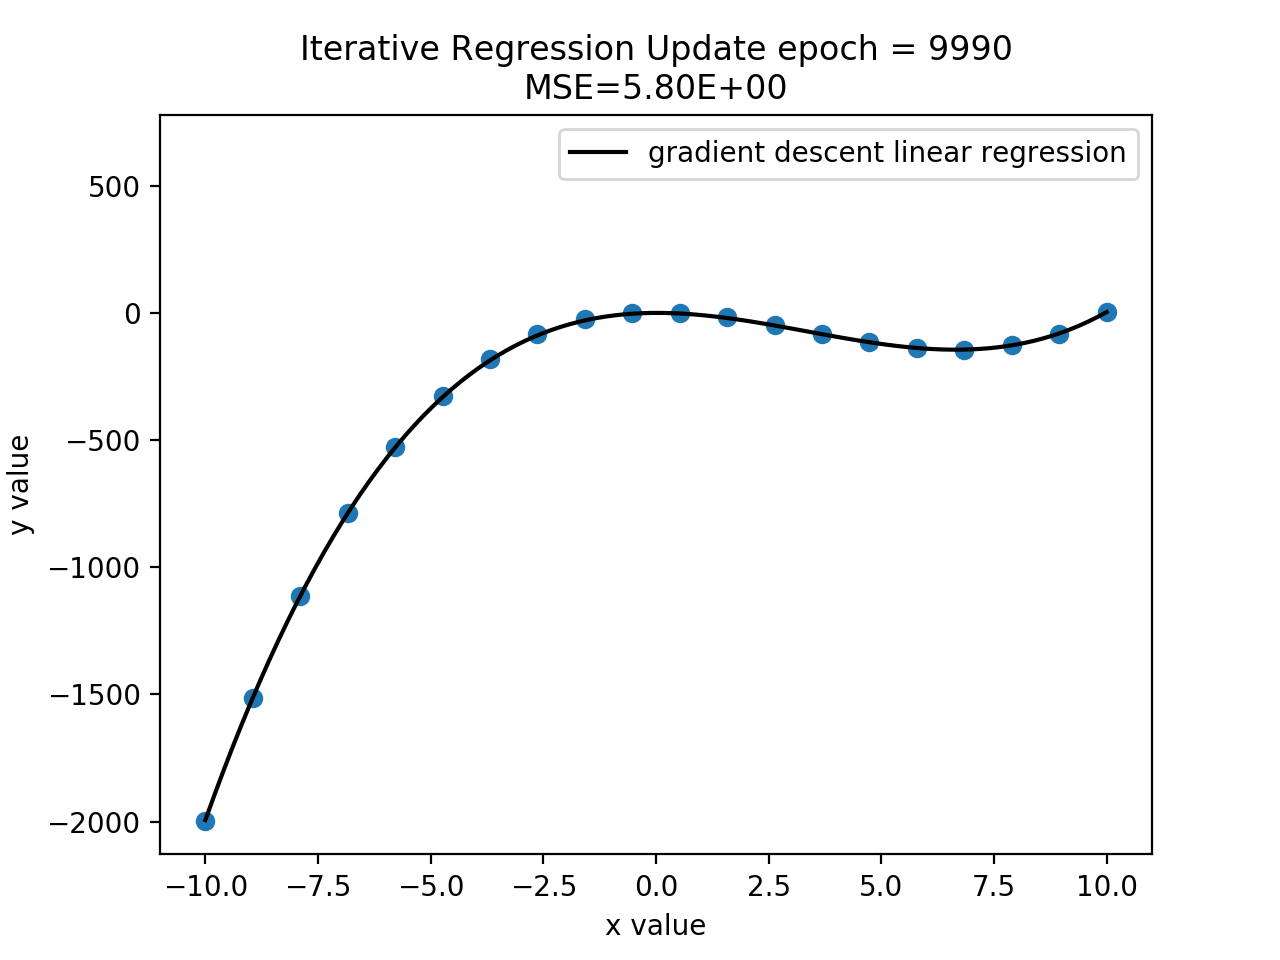

In [20]:
%matplotlib notebook
plot_regression(X, y, poly_history, predict, 10)

We see that our extension is able to support and generalize to various different problems just by defining the appropriate objective function or extending the data X.